In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import read_summary

# Create a dataframe and units dict from any result summary files found:
pattern = './runs/*/result_summary.txt'
results, units = read_summary.df_from_pattern(pattern)
print('Loaded %i result files.' % len(results))
print('Columns/units:')
print(units)
print()

loading ./runs/panasas-1-1-300-0-POSIX/result_summary.txt
loading ./runs/panasas-1-2-300-0-POSIX/result_summary.txt
loading ./runs/quobyte-1-1-300-0-POSIX/result_summary.txt
loading ./runs/quobyte-1-2-300-0-POSIX/result_summary.txt
loading ./runs/panasas-1-4-300-0-POSIX/result_summary.txt
loading ./runs/quobyte-1-4-300-0-POSIX/result_summary.txt
loading ./runs/panasas-1-16-300-0-POSIX/result_summary.txt
loading ./runs/quobyte-1-16-300-0-POSIX/result_summary.txt
loading ./runs/panasas-2-2-300-0-POSIX/result_summary.txt
loading ./runs/quobyte-2-2-300-0-POSIX/result_summary.txt
loading ./runs/panasas-10-2-300-0-POSIX/result_summary.txt
loading ./runs/quobyte-10-2-300-0-POSIX/result_summary.txt
loading ./runs/panasas-1-1-300-1-POSIX/result_summary.txt
loading ./runs/panasas-1-1-300-2-POSIX/result_summary.txt
loading ./runs/quobyte-1-1-300-1-POSIX/result_summary.txt
loading ./runs/quobyte-1-1-300-2-POSIX/result_summary.txt
loading ./runs/panasas-1-2-300-1-POSIX/result_summary.txt
loading ./

In [2]:
# Define utilities
def describe(df):
    """ Given a dataframe, return a dict (constants, variables) where both are dicts keyed by column name:
            - Values in `constants` are the single value from that column.
            - Values in `variables` are a list of sorted unique values from that column.
    """
    constants = {}
    variables = {}
    for c in df.columns:
        vs = set(df[c])
        if len(vs) == 1:
            constants[c] = df[c].iloc[0]
        else:
            variables[c] = sorted(list(vs))
    return constants, variables

# Characterise columns as bandwidth, IOPs, or descriptive:
# print('units:', units)
bw_unit = 'GiB/s'
iops_unit = 'kIOPS'
score_cols = [c for c, u in units.items() if 'score' in c]
print('score_cols:', score_cols)
descr_cols = [c for c, u in units.items() if (u is None and 'score' not in c)]
print('descr_cols:', descr_cols)
bw_cols = [c for c, u in units.items() if (u == bw_unit and 'score' not in c)]
print('bw_cols:', bw_cols)
iops_cols = [c for c, u in units.items() if (u == iops_unit and 'score' not in c)]
print('iops_cols:', iops_cols)
metric_names = {
    bw_unit: 'Bandwidth',
    iops_unit: 'IOPs',
}

print('Test matrix summary:')
result_consts, result_vars = describe(results[descr_cols])
for k, v in result_consts.items():
    print(k, ':', v)
for k, v in result_vars.items():
    print(k,':', list(v))

score_cols: ['bandwidth-score', 'iops-score', 'total-score']
descr_cols: ['nodes', 'ntasks_per_node', 'filesystem.name', 'filesystem.mountpoint', 'stonewall', 'iters', 'time', 'ior_api']
bw_cols: ['ior-easy-write', 'ior-hard-write', 'ior-easy-read', 'ior-hard-read']
iops_cols: ['mdtest-easy-write', 'mdtest-hard-write', 'find', 'mdtest-easy-stat', 'mdtest-hard-stat', 'mdtest-easy-delete', 'mdtest-hard-read', 'mdtest-hard-delete']
Test matrix summary:
stonewall : 300
time : 4:0:0
nodes : [1, 2, 10]
ntasks_per_node : [1, 2, 4, 16, 32]
filesystem.name : ['panasas', 'pure', 'quobyte']
filesystem.mountpoint : ['/gws/nopw/j04/perf_testing3/stackhpc', '/gws/pw/j07/perf_testing3', '/work/stackhpc-pure/']
iters : [0, 1, 2]
ior_api : ['MPIIO', 'POSIX']


In [3]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from collections import namedtuple

# create legend entries - colours here will be used to set bar colors too:
BAR_LEGEND={
    'pure': Patch(color='tab:blue'),
    'panasas': Patch(color='tab:orange'),
    'quobyte': Patch(color='tab:green'),
    'max of any repeat': Patch(color='tab:gray'),
    '25 Gb/s': Line2D([0], [0], color='tab:red', linewidth=1, linestyle='--'),
    '50 Gb/s': Line2D([0], [0], color='tab:red', linewidth=1, linestyle='-'),
}
for k, artist in BAR_LEGEND.items():
    artist.set(label=k)

def plot_bars(subresults):
    """ Plot 2x barcharts per row, MPIIO and POSIX apis, where a row is an io500 test e.g. ior-easy-write.
        Bars are coloured by stonewall time and filesystem.
    """
    grouper = ['nodes', 'ntasks_per_node', 'filesystem.name', 'stonewall', 'ior_api']
    color_options = { # see tableau palette https://matplotlib.org/stable/gallery/color/named_colors.html
                'pure': 'tab:blue',
                'panasas': 'tab:orange',
                'quobyte': 'tab:green',
                'max of any repeat': 'tab:gray',
    }
    # legend_entries = [mpatches.Patch(color=v, label=k) for k, v in color_options.items()] + [Line2D([0], [0], color=cmap(0.), lw=4),
    grouped = subresults.groupby('ior_api')
    for col in bw_cols + iops_cols:
        fig, axs = plt.subplots(figsize=(20, 4), nrows=1, ncols=len(grouped), sharey=True)
        for ig, (g, group) in enumerate(grouped):
            ax = axs[ig] if len(grouped) > 1 else axs
            mins = group.groupby(grouper).min().reset_index() # reset ditches heirarchical index
            maxs = group.groupby(grouper).max().reset_index()
                
            barcolors = [BAR_LEGEND[z].get_facecolor() for z in mins['filesystem.name']]
                
            labels = mins[grouper].astype(str).agg('-'.join, axis='columns')
            y_pos=range(len(mins))
            ax.bar(y_pos, maxs[col], width=0.8, label='min', color='darkgray')
            ax.bar(y_pos, mins[col], width=0.8, label='max', color=barcolors)
            ax.set_xticks(y_pos, labels, rotation=90)
            ax.set_ylabel(f"{ metric_names[units[col]] } ({ units[col] })")
            ax.set_title(f'{ col }: IOR API={ g }')
            ax.grid(visible=True, axis='y')
            
            # sharey turns off tick labels on the shared axes. However resetting as below breaks github rendering:
            # ax.tick_params(axis='y', labelleft=True)
            if units[col] == bw_unit:
                for gbit in (25, 50):
                    GiBytes = ((gbit / 8) * 1E9) / 1024**3
                    art = BAR_LEGEND[f'{gbit} Gb/s']
                    ax.axhline(GiBytes, color=art.get_color(), linewidth=art.get_linewidth(), linestyle=art.get_linestyle())
            
        if len(grouped) > 1: # only add legend to RH plot:
            axs[1].legend(handles=BAR_LEGEND.values())
        else:
            axs.legend(handles=BAR_LEGEND.values())

# Single-node POSIX results
<a id='Single-node POSIX results'><a id='Single-node POSIX results'></a>

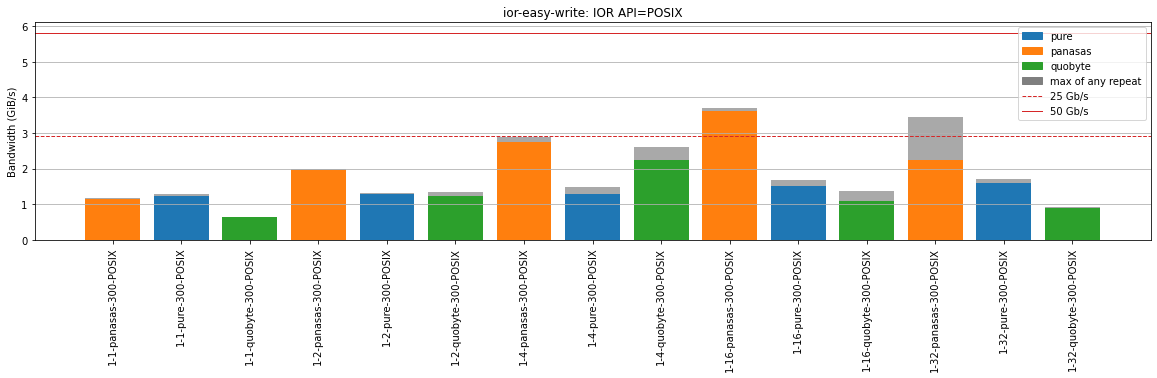

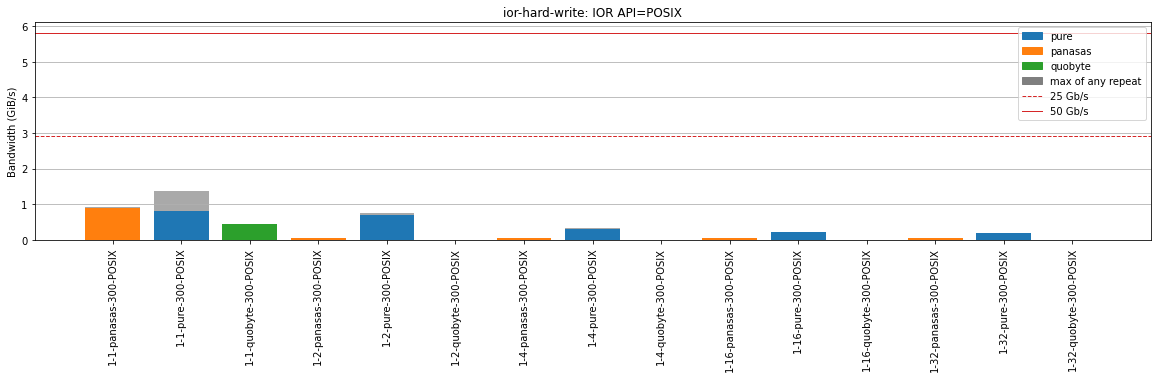

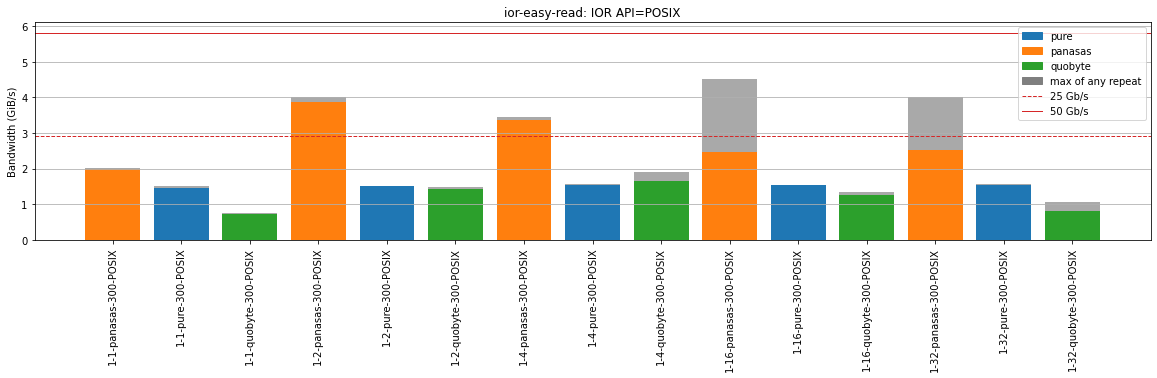

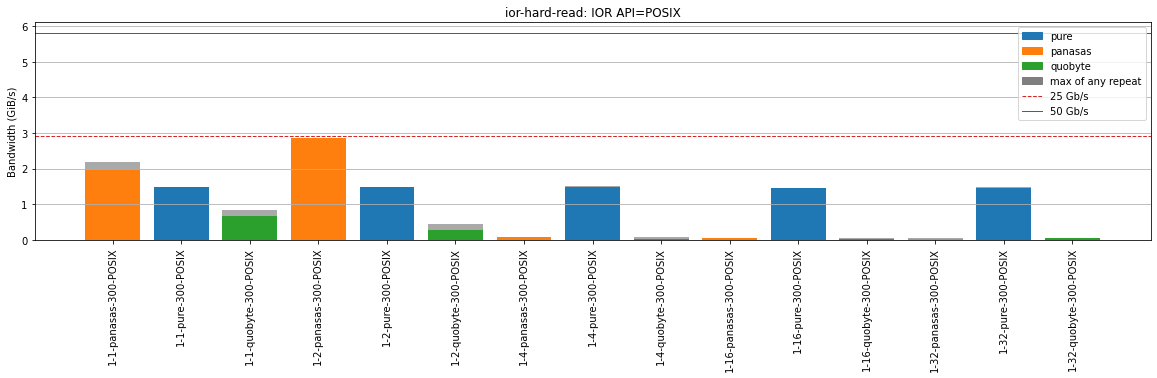

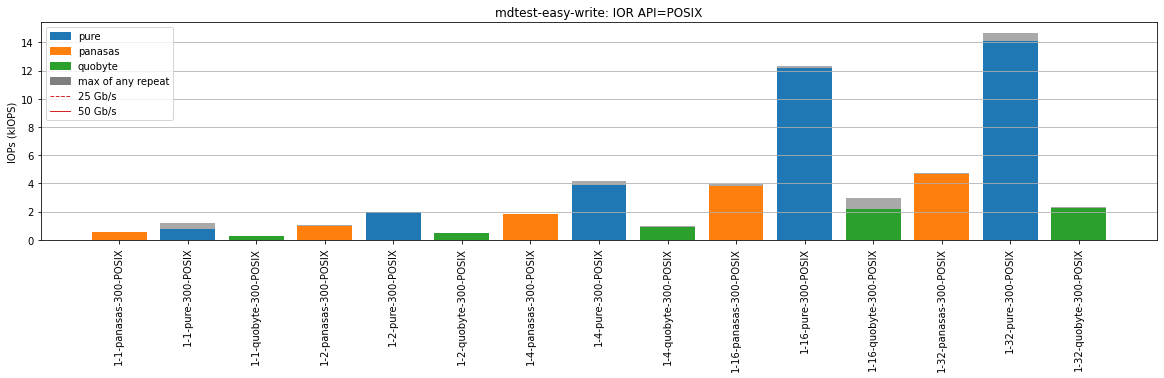

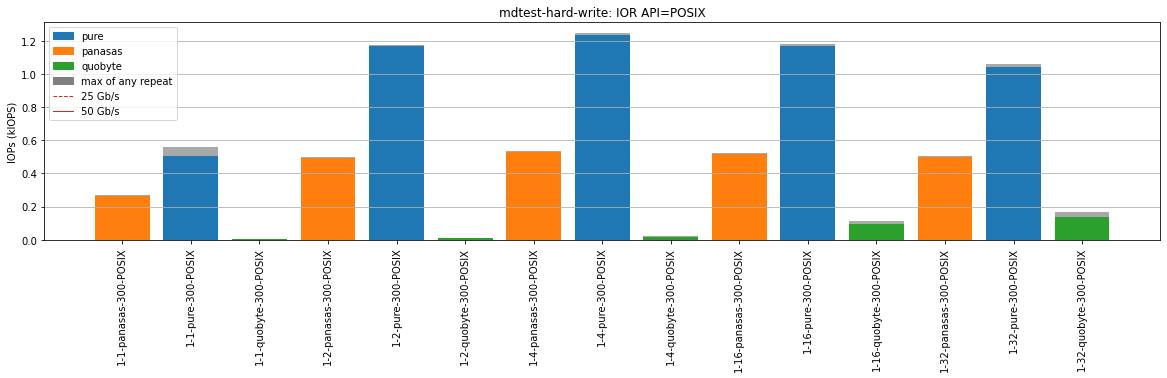

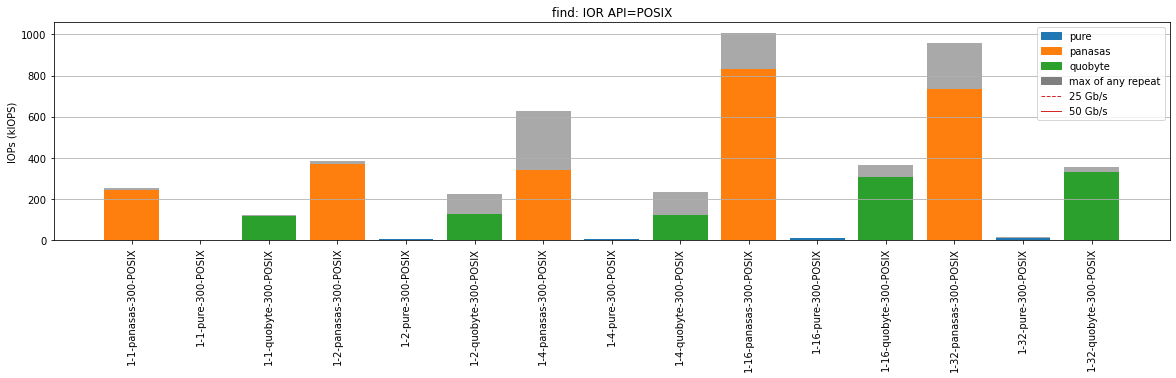

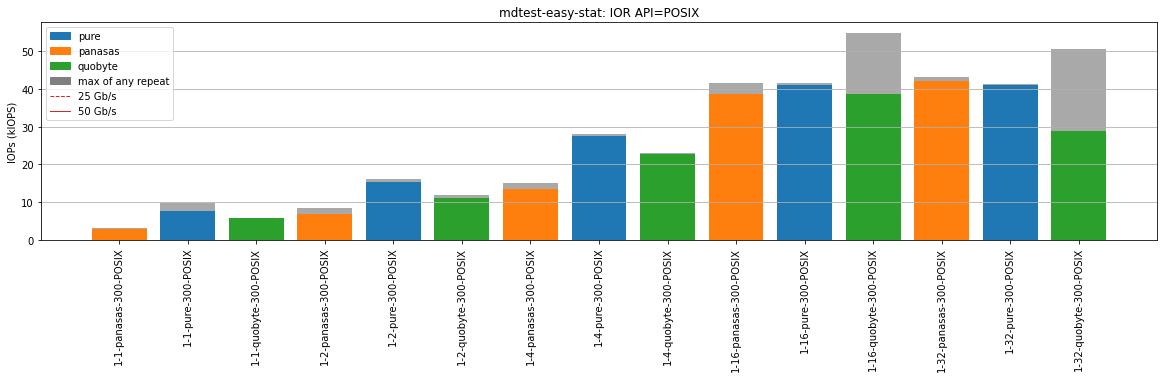

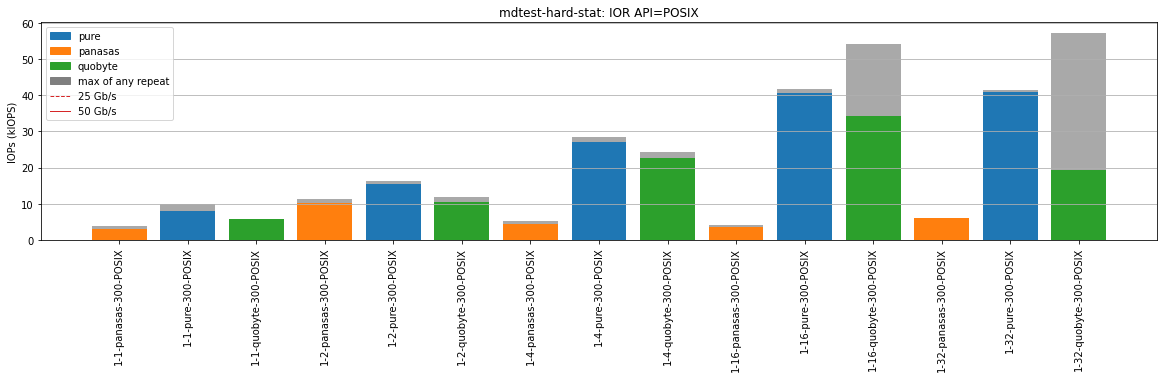

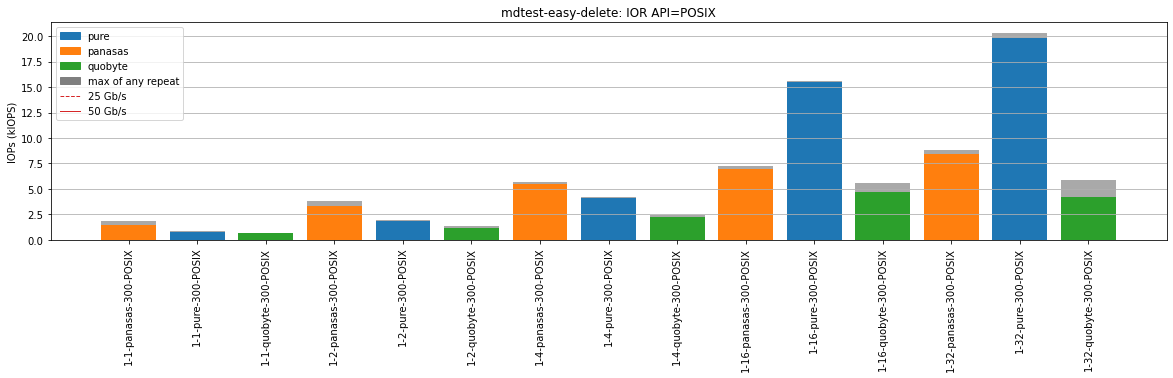

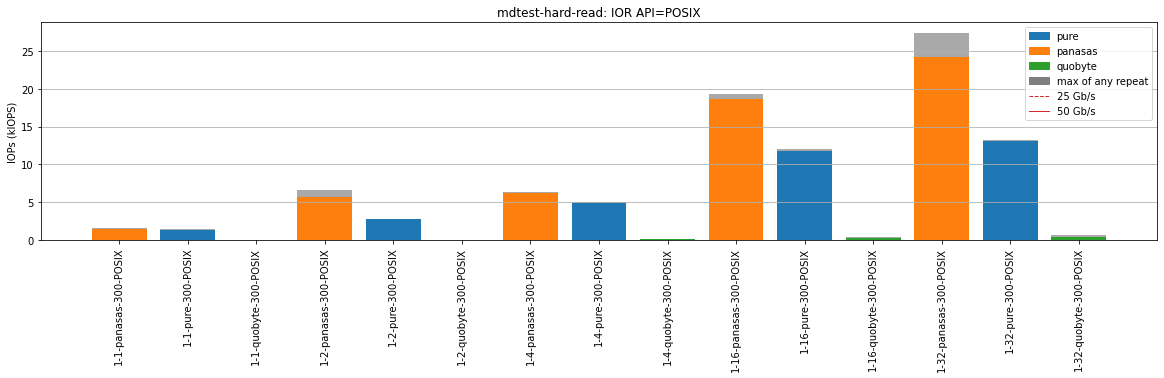

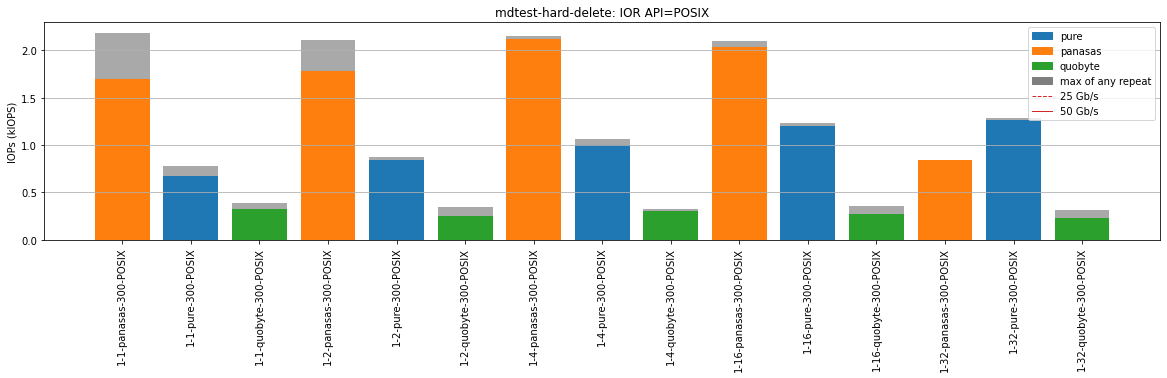

In [4]:
posix_results = results.loc[results['ior_api'] == 'POSIX']
posix_1node_results = posix_results.loc[results['nodes'] == 1]
plot_bars(posix_1node_results)

# POSIX node scaling - 2 processes per node

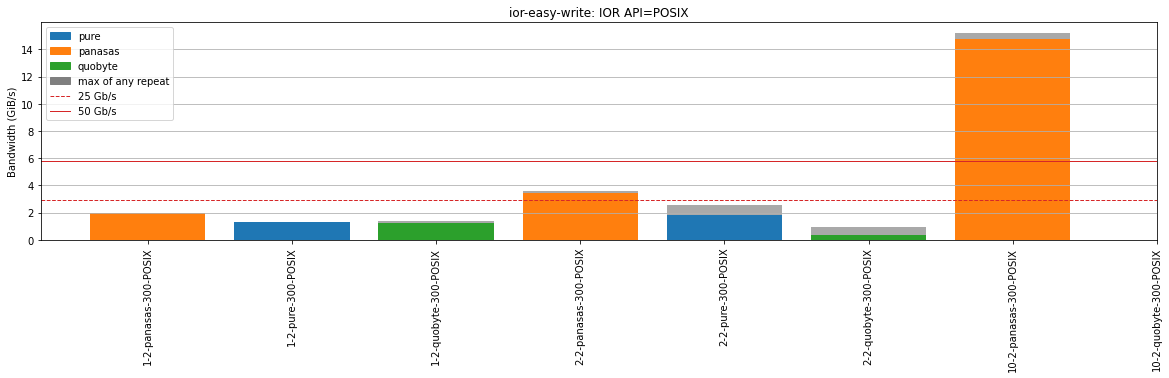

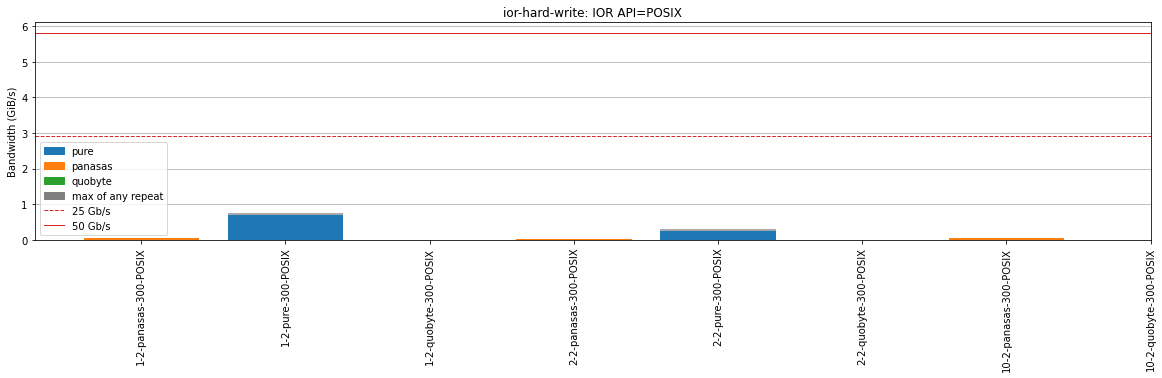

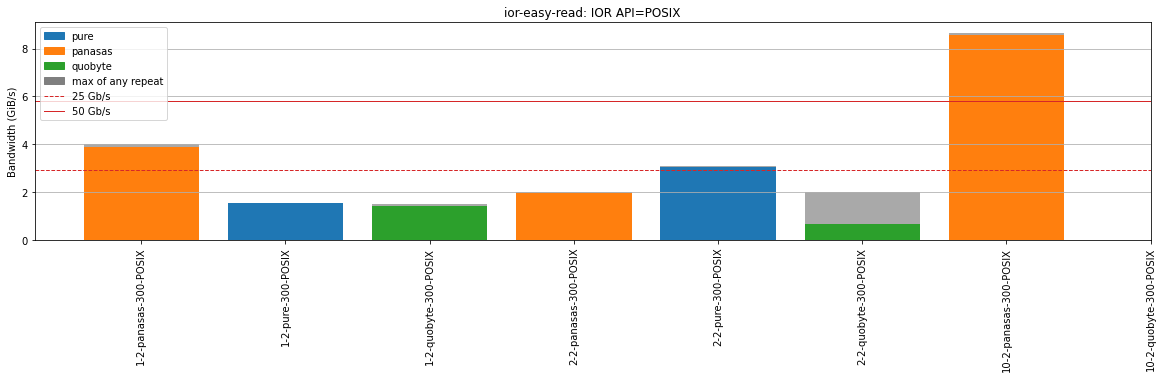

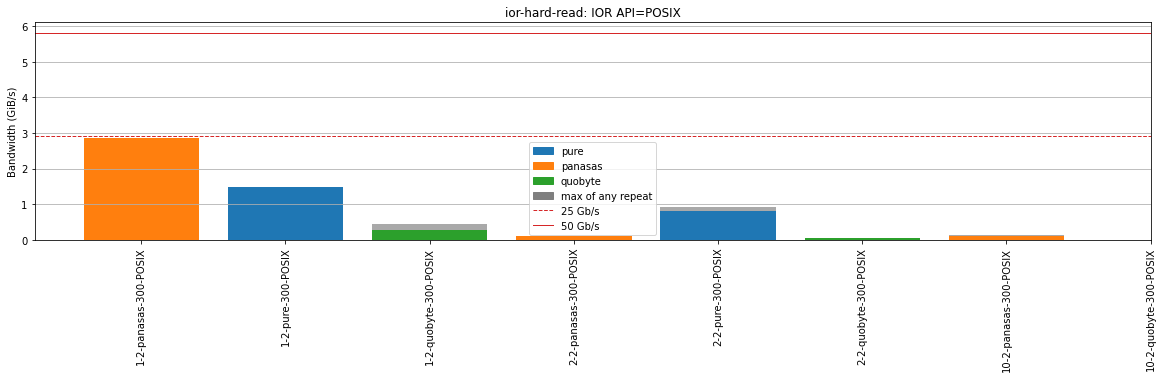

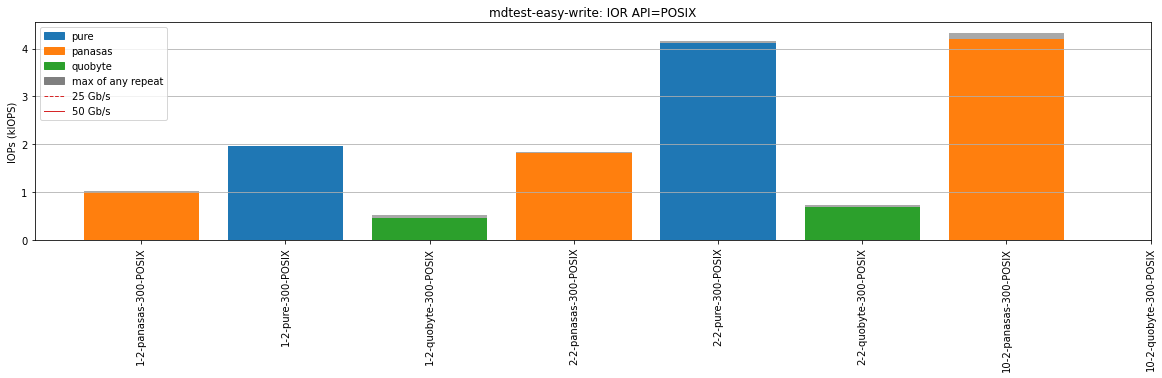

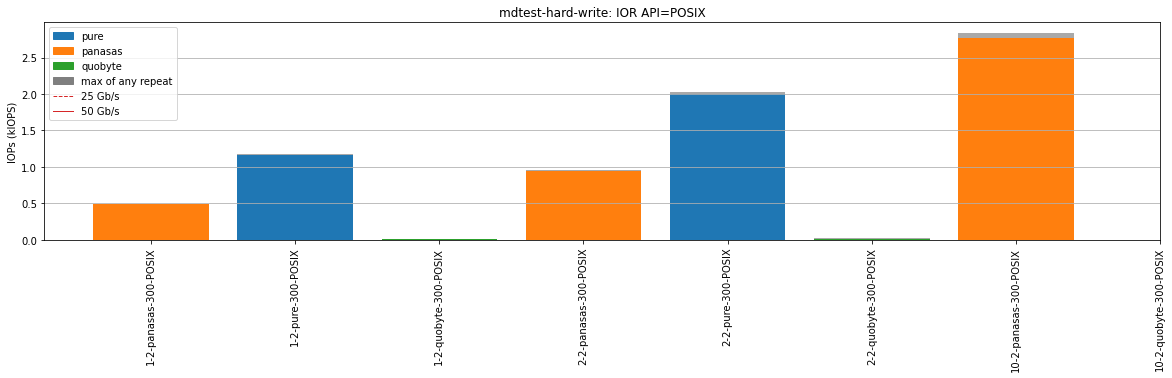

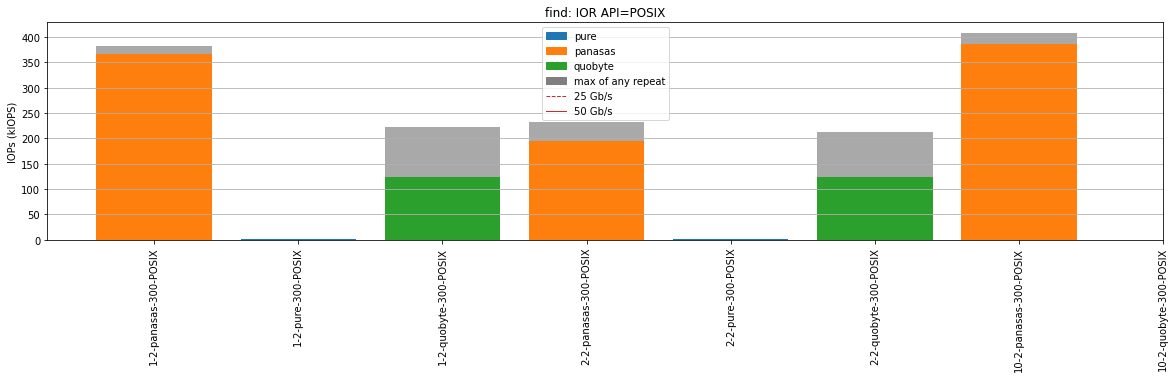

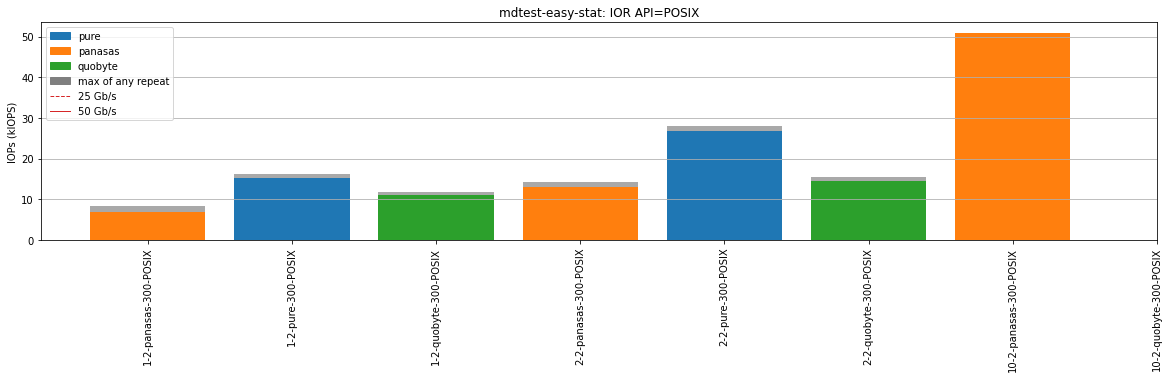

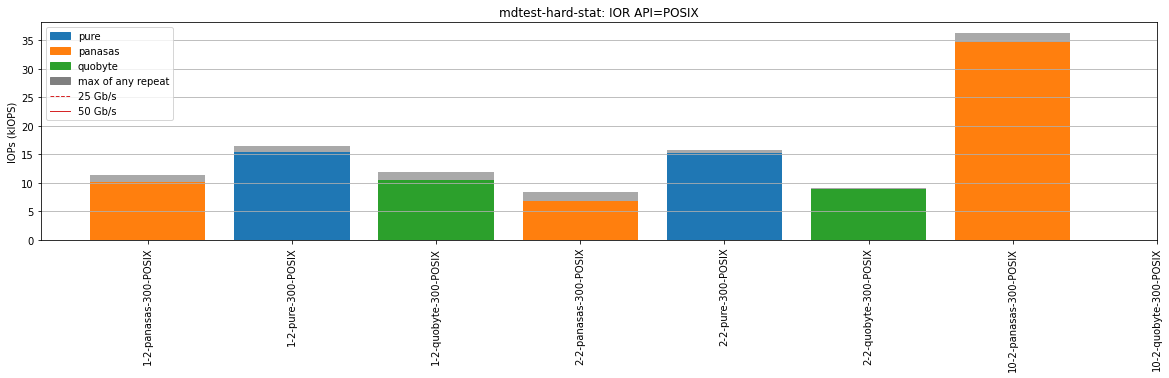

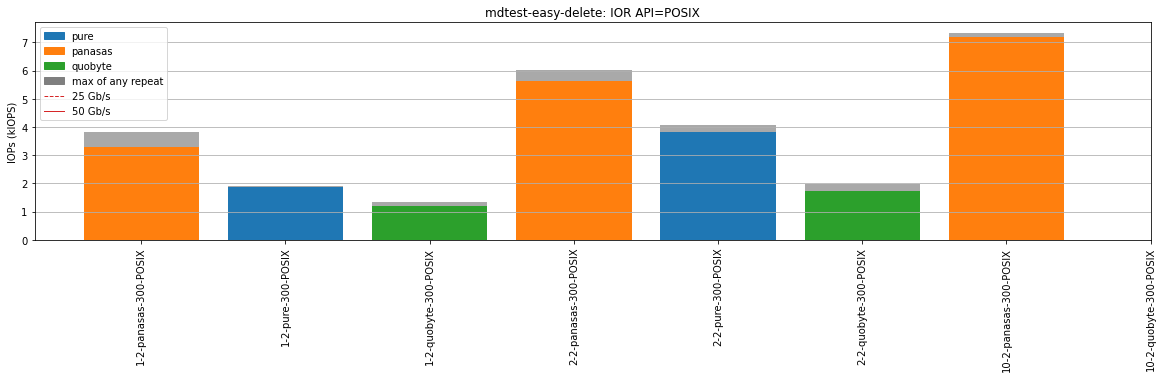

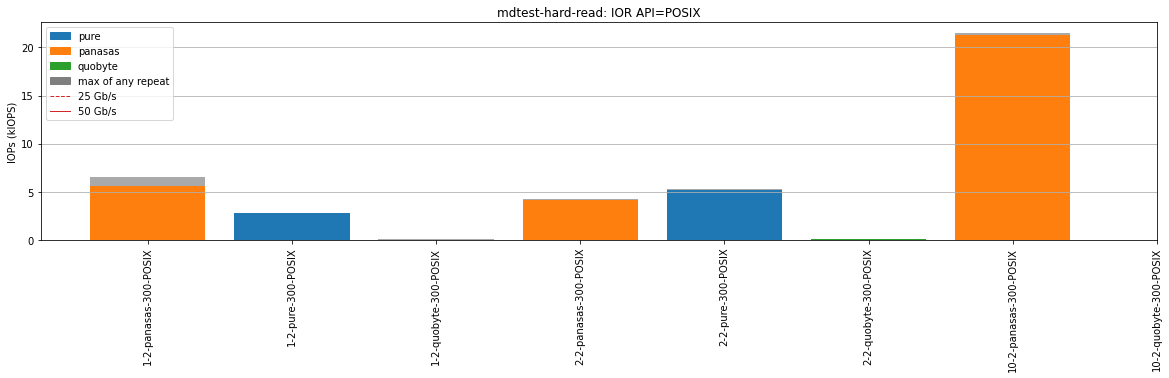

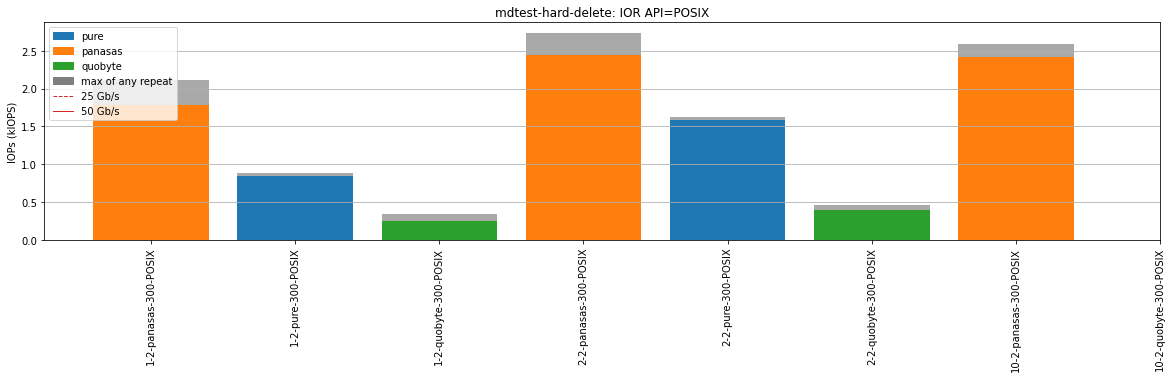

In [5]:
posix_2procs_results = posix_results.loc[posix_results['ntasks_per_node'] == 2]
plot_bars(posix_2procs_results)

# POSIX node scaling - 16 processes per node

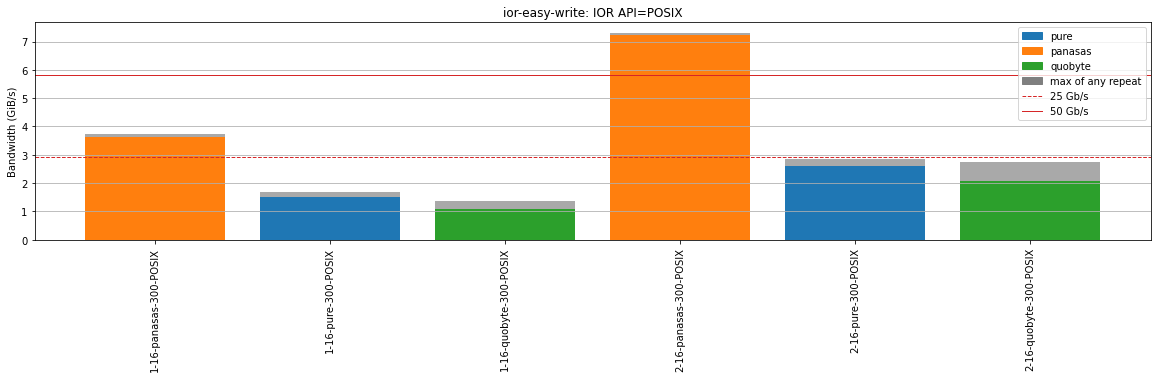

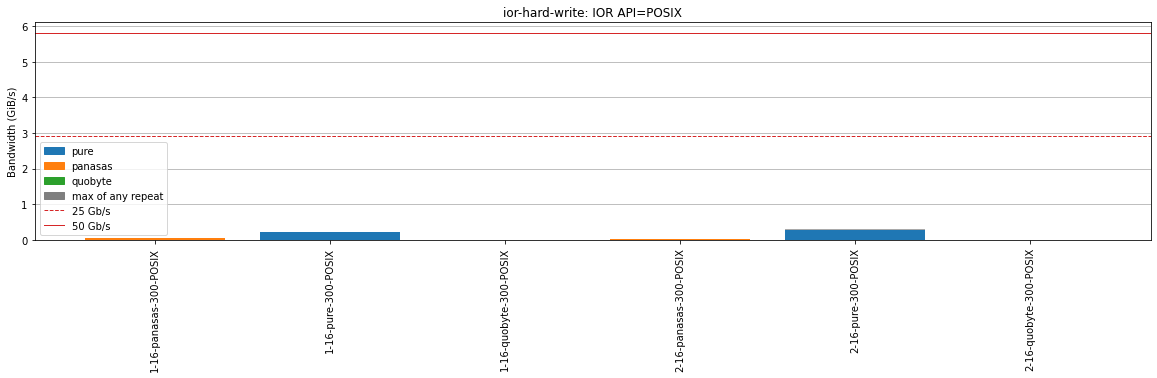

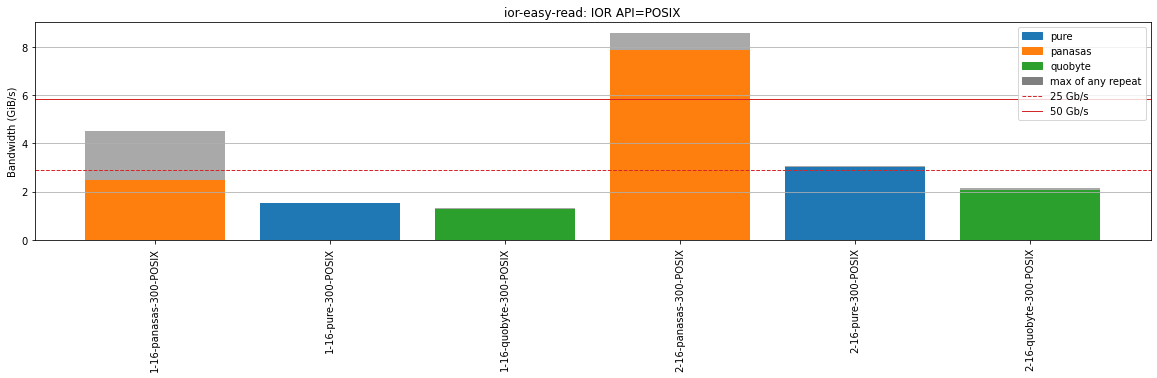

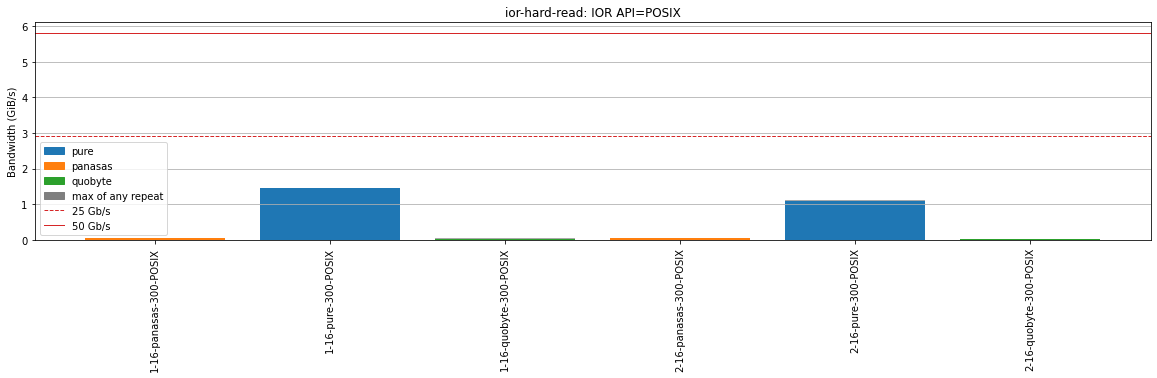

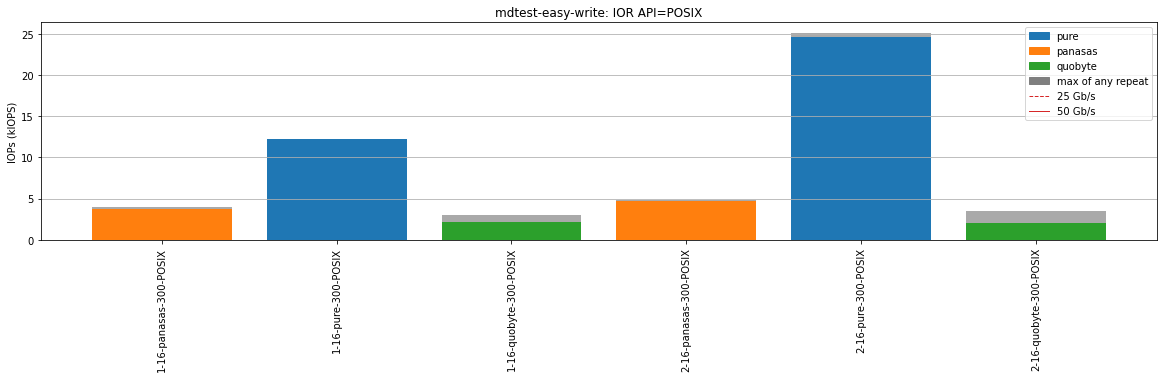

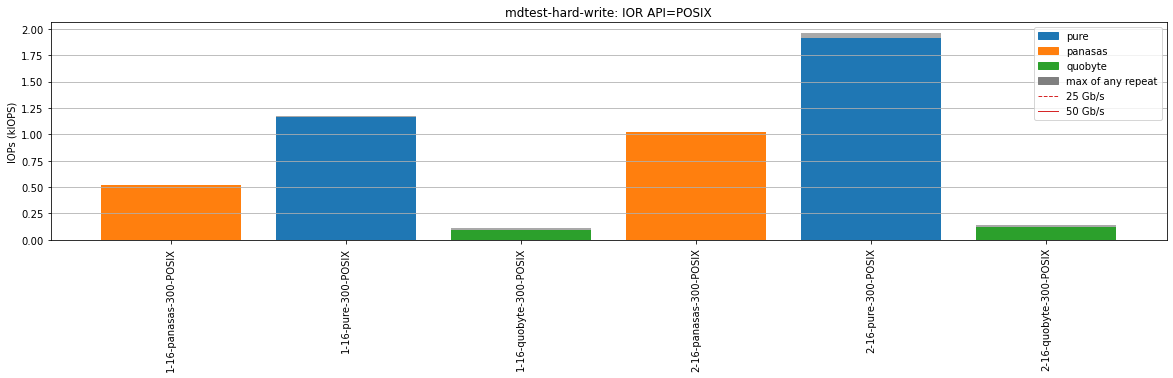

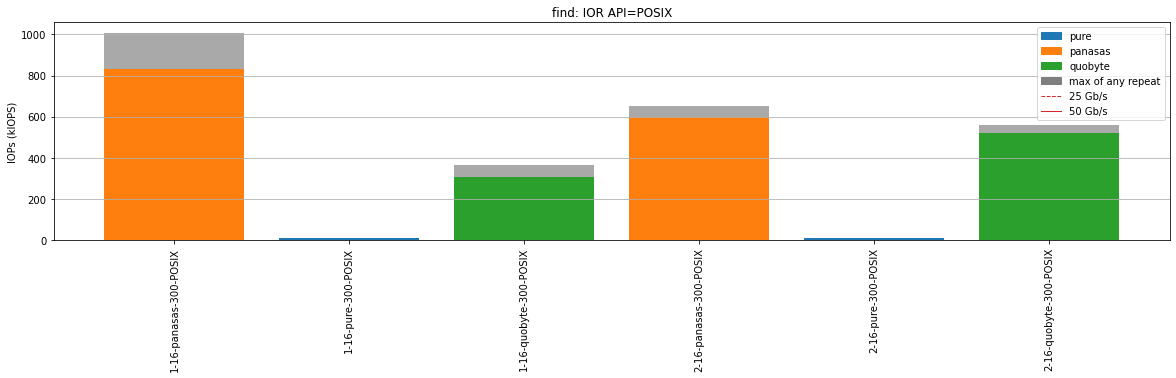

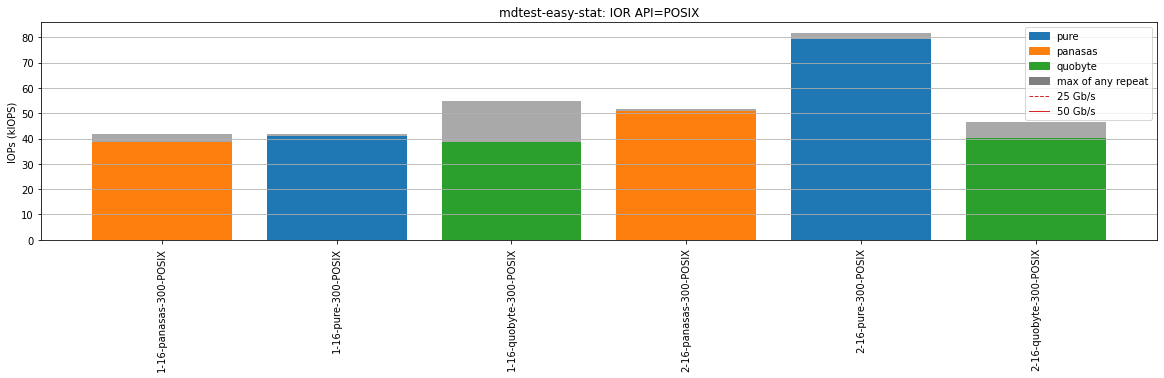

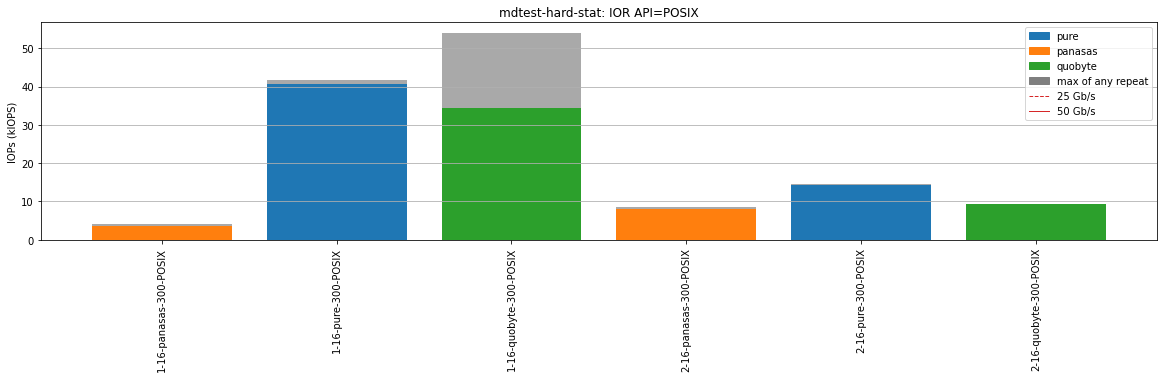

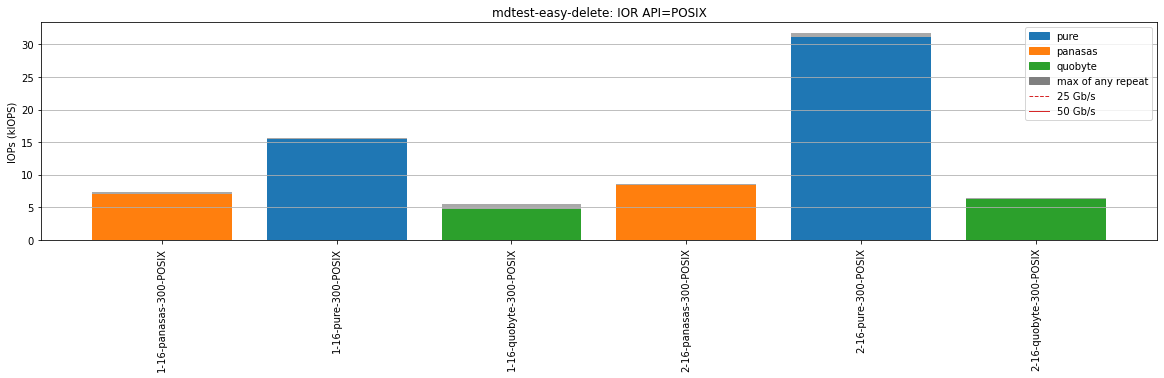

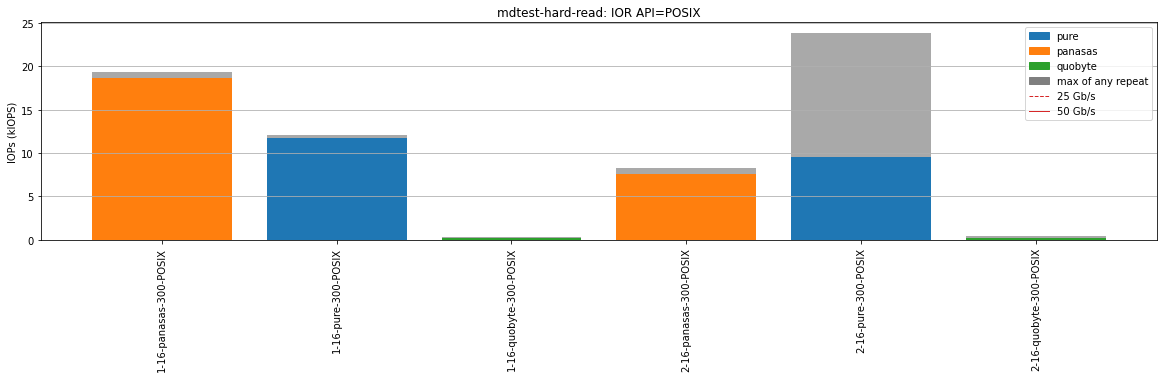

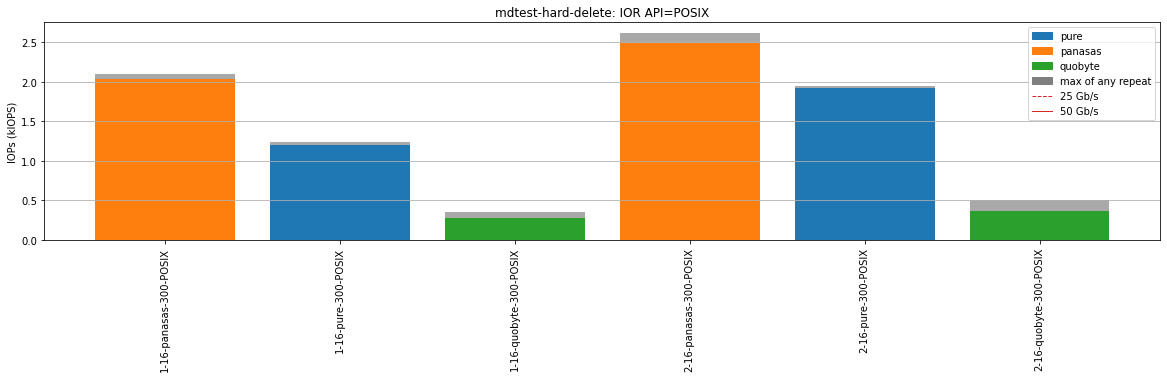

In [6]:
posix_16procs_results = posix_results.loc[posix_results['ntasks_per_node'] == 16]
plot_bars(posix_16procs_results)

# POSIX vs MPIIO

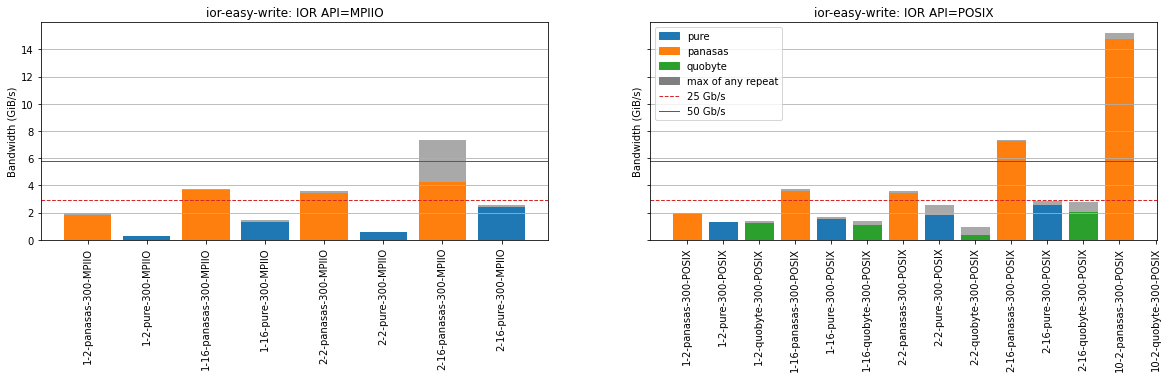

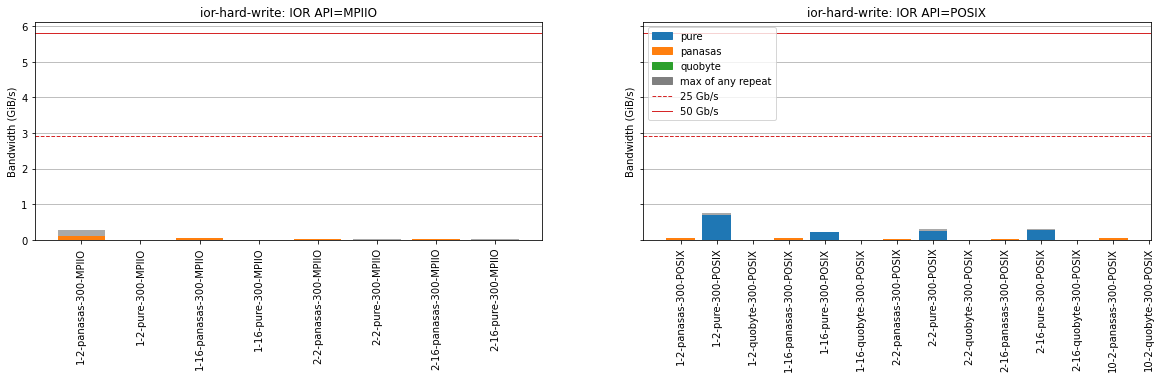

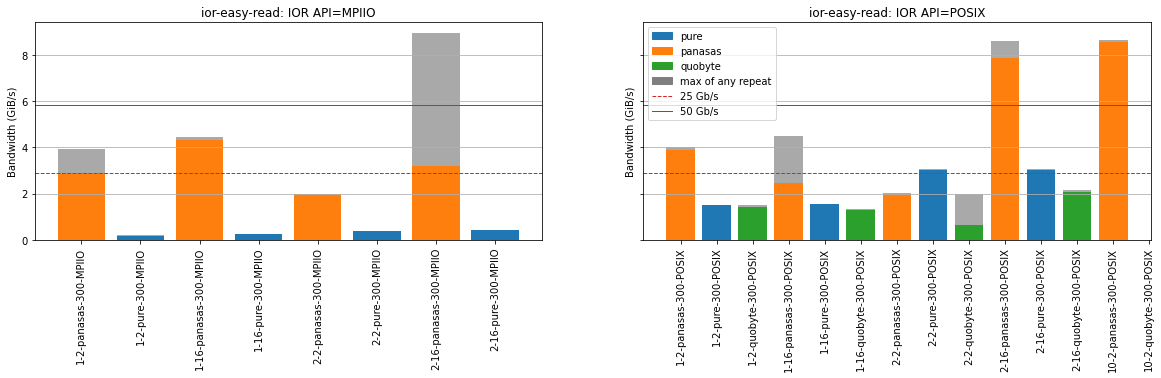

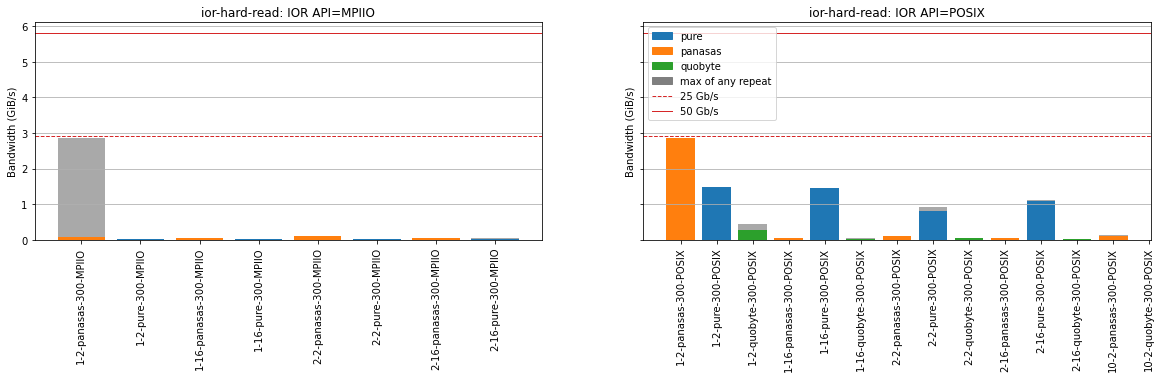

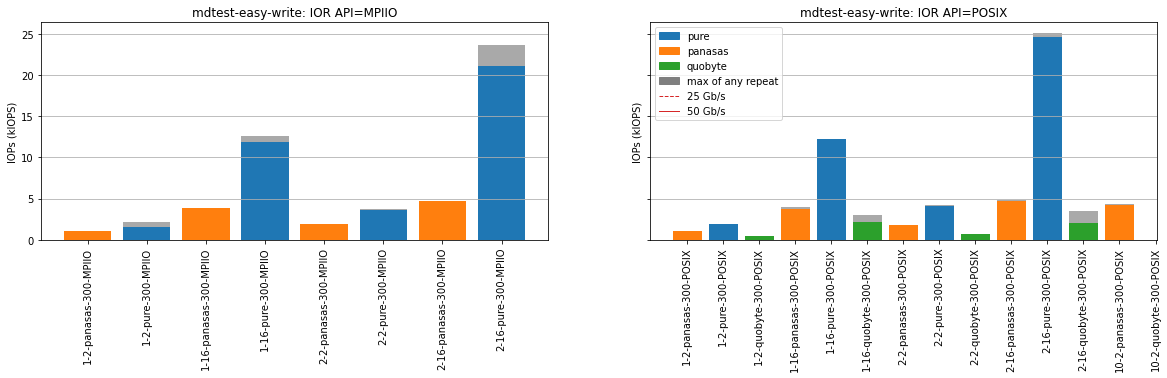

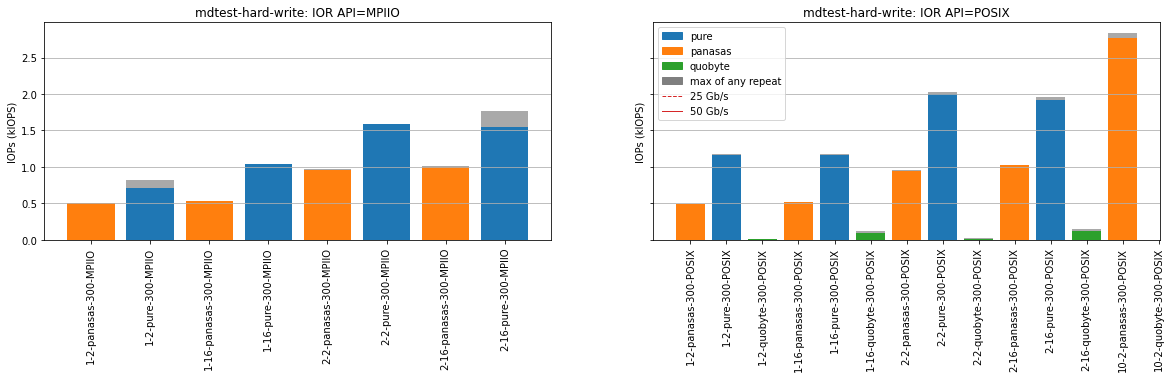

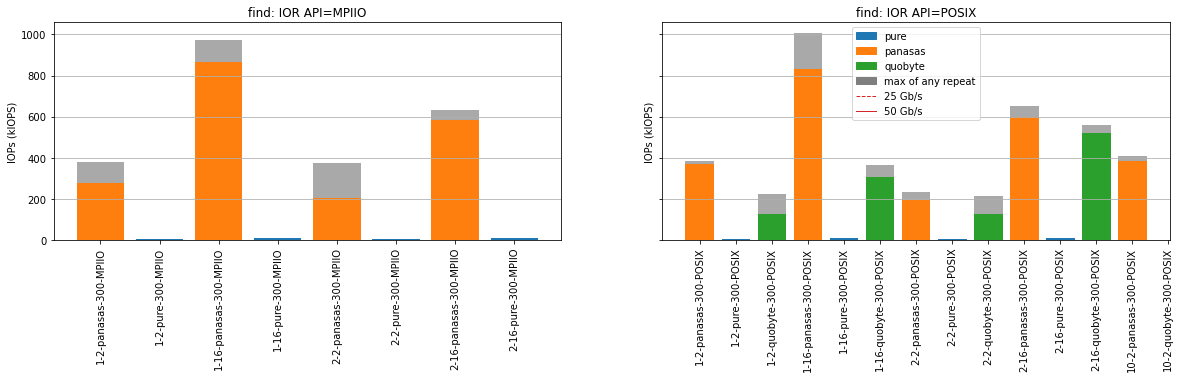

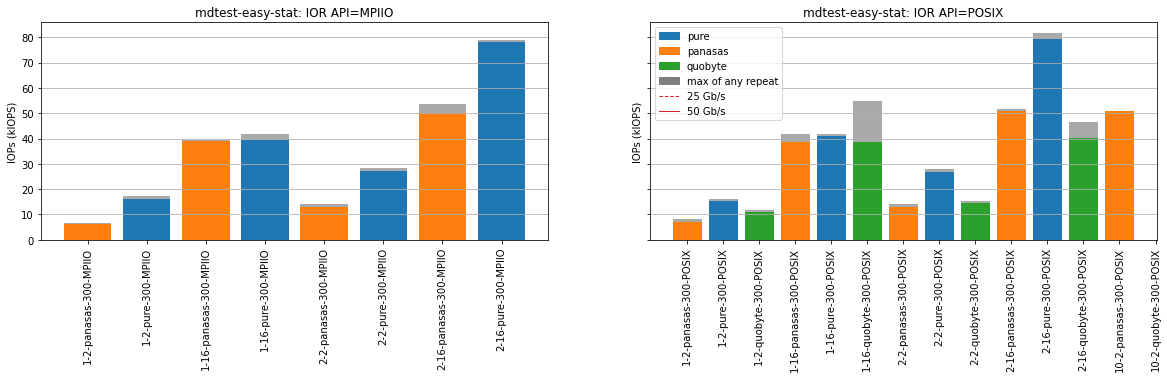

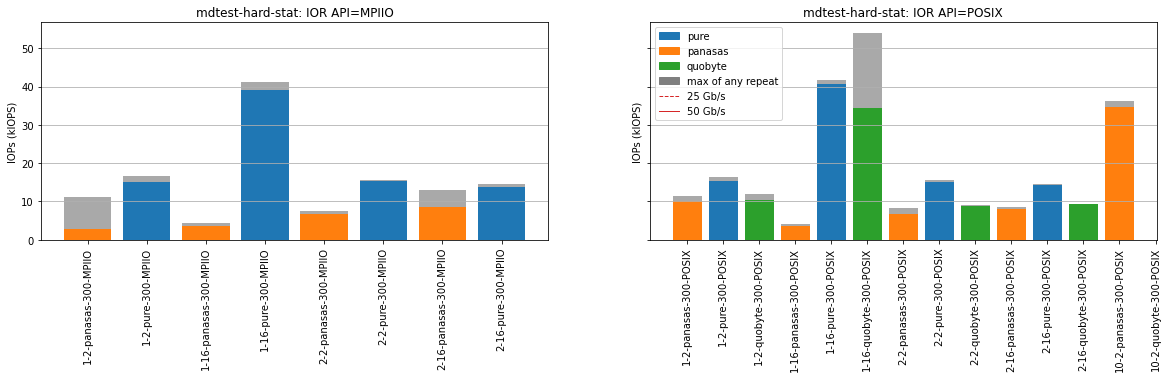

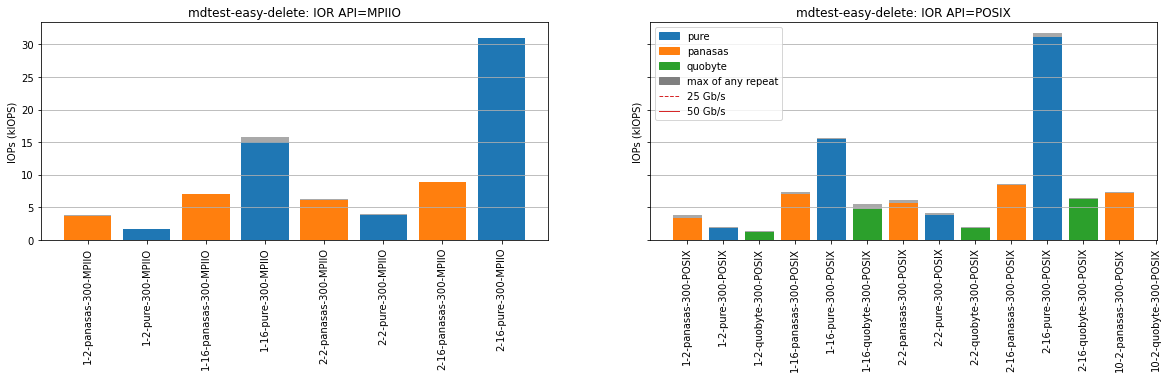

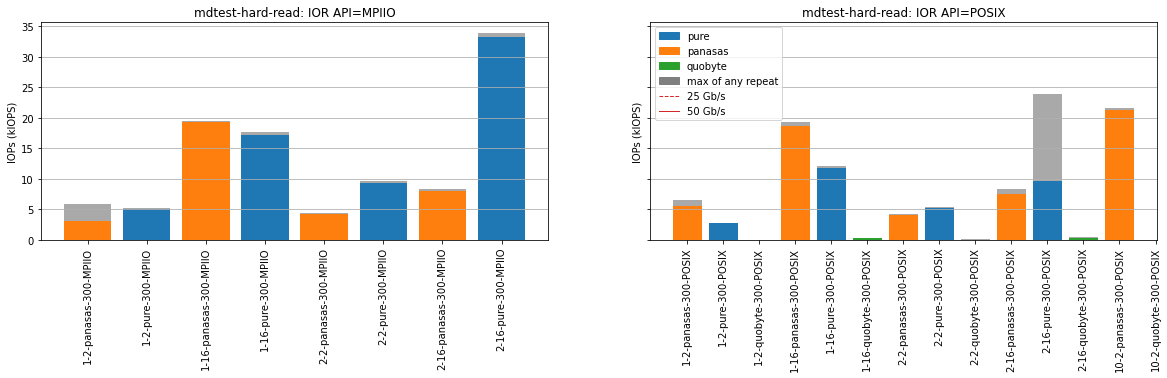

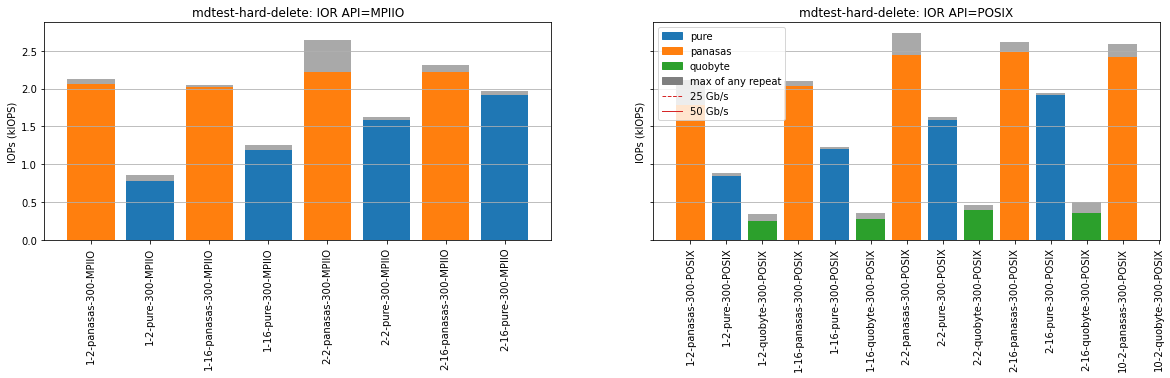

In [7]:
# mpiio_results = results.loc[results['ior_api'] == 'MPIIO']
api_results = results.loc[results['ntasks_per_node'].isin([2, 16])]
#posix_results = results.loc[results['ior_api'] == 'POSIX']
# posix_1node_results = posix_results.loc[results['nodes'] == 1]
plot_bars(api_results)

In [8]:
results.to_csv('all-results.csv')